In [1]:
!python --version


Python 3.11.11


In [2]:
!git clone https://github.com/decodingml/personalized-recommender-course.git
%cd personalized-recommender-course

Cloning into 'personalized-recommender-course'...
remote: Enumerating objects: 927, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 927 (delta 41), reused 50 (delta 27), pack-reused 837 (from 1)
Receiving objects: 100% (927/927), 4.38 MiB | 9.16 MiB/s, done.
Resolving deltas: 100% (565/565), done.
/content/personalized-recommender-course


In [3]:
!make install

Streaming output truncated to the last 5000 lines.
nvidia-cudnn-cu12 ------------------------------ 96.92 MiB/633.96 MiB
⠼ Preparing packages... (189/200)
plotly     ------------------------------ 11.67 MiB/14.12 MiB
nvidia-cusolver-cu12 ------------------------------ 97.18 MiB/122.01 MiB
nvidia-cusparselt-cu12 ------------------------------ 96.91 MiB/143.11 MiB
nvidia-nccl-cu12 ------------------------------ 96.98 MiB/179.91 MiB
nvidia-cusparse-cu12 ------------------------------ 96.59 MiB/197.84 MiB
nvidia-cufft-cu12 ------------------------------ 97.16 MiB/201.66 MiB
triton     ------------------------------ 98.67 MiB/241.43 MiB
nvidia-cublas-cu12 ------------------------------ 96.57 MiB/346.60 MiB
tensorflow ------------------------------ 99.11 MiB/467.18 MiB
nvidia-cudnn-cu12 ------------------------------ 97.32 MiB/633.96 MiB
⠼ Preparing packages... (189/200)
plotly     ------------------------------ 11.70 MiB/14.12 MiB
nvidia-cusolver-cu12 ------------------------------ 97.49 Mi

In [4]:
!uv run python --version

Streaming output truncated to the last 5000 lines.
tornado    ------------------------------ 124.13 KiB/426.56 KiB
pytz       ------------------------------ 38.37 KiB/496.10 KiB
hopsworks  ------------------------------ 32.00 KiB/624.75 KiB
altair     ------------------------------ 30.85 KiB/794.56 KiB
⠹ Preparing packages... (0/76)
jinja2     ------------------------------ 130.15 KiB/130.15 KiB
boto3      ------------------------------ 62.91 KiB/135.92 KiB
charset-normalizer ------------------------------ 46.87 KiB/139.24 KiB
fsspec     ------------------------------ 62.88 KiB/175.43 KiB
gitpython  ------------------------------ 124.57 KiB/202.48 KiB
google-auth ------------------------------ 92.55 KiB/204.61 KiB
psutil     ------------------------------ 189.58 KiB/280.52 KiB
protobuf   ------------------------------ 176.44 KiB/287.73 KiB
langsmith  ------------------------------ 94.80 KiB/299.77 KiB
jiter      ------------------------------ 254.66 KiB/317.88 KiB
yarl       ----------

In [5]:
!cp .env.example .env

In [6]:
import time

notebook_start_time = time.time()

# Set up environment

In [7]:
import sys
from pathlib import Path


def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False


def clone_repository() -> None:
    !git clone https://github.com/decodingml/hands-on-recommender-system.git
    %cd hands-on-recommender-system/


def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()

    root_dir = str(Path().absolute())
    print("⛳️ Google Colab environment")
else:
    root_dir = str(Path().absolute().parent)
    print("⛳️ Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    print(f"Adding the following directory to the PYTHONPATH: {root_dir}")
    sys.path.append(root_dir)

Streaming output truncated to the last 5000 lines.
pandas     ------------------------------ 6.07 MiB/11.67 MiB
botocore   ------------------------------ 3.94 MiB/12.74 MiB
nvidia-cuda-cupti-cu12 ------------------------------ 5.90 MiB/13.17 MiB
nvidia-nvjitlink-cu12 ------------------------------ 6.00 MiB/20.09 MiB
nvidia-cuda-nvrtc-cu12 ------------------------------ 5.86 MiB/23.50 MiB
nvidia-curand-cu12 ------------------------------ 6.06 MiB/53.70 MiB
catboost   ------------------------------ 6.18 MiB/93.98 MiB
nvidia-cusolver-cu12 ------------------------------ 6.10 MiB/122.01 MiB
nvidia-cusparse-cu12 ------------------------------ 5.85 MiB/197.84 MiB
nvidia-cufft-cu12 ------------------------------ 6.18 MiB/201.66 MiB
nvidia-cublas-cu12 ------------------------------ 5.88 MiB/346.60 MiB
tensorflow ------------------------------ 6.05 MiB/467.18 MiB
⠴ Preparing packages... (45/63)
langchain  ------------------------------ 560.00 KiB/952.60 KiB
jedi       ---------------------------

# 🧬 Training pipeline: Training retrieval model

In this notebook, you will train a retrieval model that will be able to quickly generate a small subset of candidate items from a large collection of items. Your model will be based on the *two-tower architecture*, which embeds queries and candidates (keys) into a shared low-dimensional vector space. Here, a query consists of features of a customer and a transaction (e.g. timestamp of the purchase), whereas a candidate consists of features of a particular item. All queries will have a user ID and all candidates will have an item ID, and the model will be trained such that the embedding of a user will be close to all the embeddings of items the user has previously bought.

After training the model you will save and upload its components to the Hopsworks Model Registry.

Let's go ahead and load the data.

## 📝 Imports

In [8]:
%load_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")

from loguru import logger

from recsys import hopsworks_integration, training
from recsys.config import settings

## Constants

In [9]:
from pprint import pprint

pprint(dict(settings))

{'CUSTOMER_DATA_SIZE': <CustomerDatasetSize.SMALL: 'SMALL'>,
 'CUSTOM_HOPSWORKS_INFERENCE_ENV': 'custom_env_name',
 'FEATURES_EMBEDDING_MODEL_ID': 'all-MiniLM-L6-v2',
 'HOPSWORKS_API_KEY': None,
 'OPENAI_API_KEY': None,
 'OPENAI_MODEL_ID': 'gpt-4o-mini',
 'RANKING_DATASET_VALIDATON_SPLIT_SIZE': 0.1,
 'RANKING_EARLY_STOPPING_ROUNDS': 5,
 'RANKING_ITERATIONS': 100,
 'RANKING_LEARNING_RATE': 0.2,
 'RANKING_MODEL_TYPE': 'ranking',
 'RANKING_SCALE_POS_WEIGHT': 10,
 'RECSYS_DIR': PosixPath('/content/personalized-recommender-course/hands-on-recommender-system/recsys'),
 'TWO_TOWER_DATASET_TEST_SPLIT_SIZE': 0.1,
 'TWO_TOWER_DATASET_VALIDATON_SPLIT_SIZE': 0.1,
 'TWO_TOWER_LEARNING_RATE': 0.01,
 'TWO_TOWER_MODEL_BATCH_SIZE': 2048,
 'TWO_TOWER_MODEL_EMBEDDING_SIZE': 16,
 'TWO_TOWER_NUM_EPOCHS': 10,
 'TWO_TOWER_WEIGHT_DECAY': 0.001}


## <span style="color:#ff5f27">🔮 Connect to Hopsworks Feature Store </span>

In [10]:
project, fs = hopsworks_integration.get_feature_store()

2025-02-19 03:40:34.346 | INFO     | recsys.hopsworks_integration.feature_store:get_feature_store:18 - Login to Hopsworks using cached API key.


Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated

Paste it here: ··········

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1213603


## <span style="color:#ff5f27">Create Hopsworks Feature Views </span>

In Hopsworks, you write features to feature groups (where the features are stored) and you read features from feature views. A feature view is a logical view over features, stored in feature groups, and a feature view typically contains the features used by a specific model. This way, feature views enable features, stored in different feature groups, to be reused across many different models.

More in their [Feature Views](https://docs.hopsworks.ai/3.1/concepts/fs/feature_view/fv_overview/) docs.

In [11]:
feature_view = hopsworks_integration.feature_store.create_retrieval_feature_view(fs)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1213603/fs/1201233/fv/retrieval/version/1


To view and explore data in the feature view you can retrieve batch data using the `get_batch_data()` method:

In [ ]:
# feature_view.get_batch_data()

## Create training dataset


You will train your retrieval model with a subset of features.

For the query embedding you will use:
- `customer_id`: ID of the customer.
- `age`: age of the customer at the time of purchase.
- `month_sin`, `month_cos`: time of year the purchase was made.

For the candidate embedding you will use:
- `article_id`: ID of the item.
- `garment_group_name`: type of garment.
- `index_group_name`: menswear/ladieswear etc.

In [12]:
dataset = training.two_tower.TwoTowerDataset(
    feature_view=feature_view, batch_size=settings.TWO_TOWER_MODEL_BATCH_SIZE
)
train_ds, val_ds = dataset.get_train_val_split()


2025-02-19 03:41:22.159 | INFO     | recsys.training.two_tower:get_train_val_split:263 - Retrieving and creating train, val test split...


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (7.27s) 


Let's take a look at our dataset:

In [13]:
logger.info(f"Training samples: {len(dataset.properties['train_df']):,}")
logger.info(f"Validation samples: {len(dataset.properties['val_df']):,}")

logger.info(f"Number of users: {len(dataset.properties['user_ids']):,}")
logger.info(f"Number of items: {len(dataset.properties['item_ids']):,}")

2025-02-19 03:41:48.584 | INFO     | __main__:<cell line: 0>:1 - Training samples: 16,300
2025-02-19 03:41:48.586 | INFO     | __main__:<cell line: 0>:2 - Validation samples: 2,037
2025-02-19 03:41:48.587 | INFO     | __main__:<cell line: 0>:4 - Number of users: 957
2025-02-19 03:41:48.588 | INFO     | __main__:<cell line: 0>:5 - Number of items: 11,824


In [14]:
dataset.properties["train_df"].head()

,customer_id,article_id,t_dat,price,month_sin,month_cos,age,club_member_status,age_group,garment_group_name,index_group_name
0,f7048acb8188d98bde3a5c495475a3c86faafe0eede1f2...,670265002,0,0.013542,-8.660254e-01,0.500000,48.0,ACTIVE,46-55,"Under-, Nightwear",Ladieswear
1,5d34f84e6cbe9ec4706872bb65376097af1e53f0c7dac5...,751471035,0,0.033881,1.224647e-16,-1.000000,30.0,ACTIVE,26-35,Trousers,Ladieswear
2,baf6dc7ea8575732794751bb80824fe84fd40e6af86193...,719308002,0,0.059305,5.000000e-01,-0.866025,48.0,ACTIVE,46-55,Dresses Ladies,Divided
3,56f270317dfd89a08cb095acfd70778fda7770cdaa685c...,759231002,0,0.059305,1.224647e-16,-1.000000,28.0,ACTIVE,26-35,Dresses Ladies,Ladieswear
5,6903523eabd900e34cb1448b7f5b186b5d2821f701418a...,733027006,0,0.013542,-5.000000e-01,-0.866025,21.0,ACTIVE,19-25,Jersey Fancy,Ladieswear


## Build the Two Tower model

The two tower model consist of two models:
- **Query model**: Generates a query representation of a given user and transaction features.
- **Candidate model**: Generates an item representation given item features.

**Both models produce embeddings that live in the same embedding space**. You let this space be low-dimensional to prevent overfitting on the training data. (Otherwise, the model might simply memorize previous purchases, which makes it recommend items customers already have bought).

You start with creating the query model.

In [15]:
query_model_factory = training.two_tower.QueryTowerFactory(dataset=dataset)
query_model = query_model_factory.build()

The candidate model is very similar to the query model. A difference is that it has two categorical features as input, which you one-hot encode.

In [16]:
item_model_factory = training.two_tower.ItemTowerFactory(dataset=dataset)
item_model = item_model_factory.build()

You will evaluate the two tower model using the *top-100 accuracy*. That is, for each transaction in the validation data you will generate the associated query embedding and retrieve the set of the 100 items that are closest to this query in the embedding space. The top-100 accuracy measures how often the item that was actually bought is part of this subset. To evaluate this, you create a dataset of all unique items in the training data.

Create a TwoTowerModel with the specified **query_model** and **item_model**:

In [17]:
model_factory = training.two_tower.TwoTowerFactory(dataset=dataset)
model = model_factory.build(query_model=query_model, item_model=item_model)

### Training the model

In [18]:
trainer = training.two_tower.TwoTowerTrainer(dataset=dataset, model=model)
history = trainer.train(train_ds, val_ds)

Epoch 1/10
8/8 [==============================] - 3s 111ms/step - loss: 15520.2015 - regularization_loss: 0.0000e+00 - total_loss: 15520.2015 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - val_loss: 15464.4287 - val_regularization_loss: 0.0000e+00 - val_total_loss: 15464.4287
Epoch 2/10
8/8 [==============================] - 1s 71ms/step - loss: 15321.2956 - regularization_loss: 0.0000e+00 - total_loss: 15321.2956 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_100_categorical_accuracy: 0.0000e+00

Let's take a look at the training and validation loss:

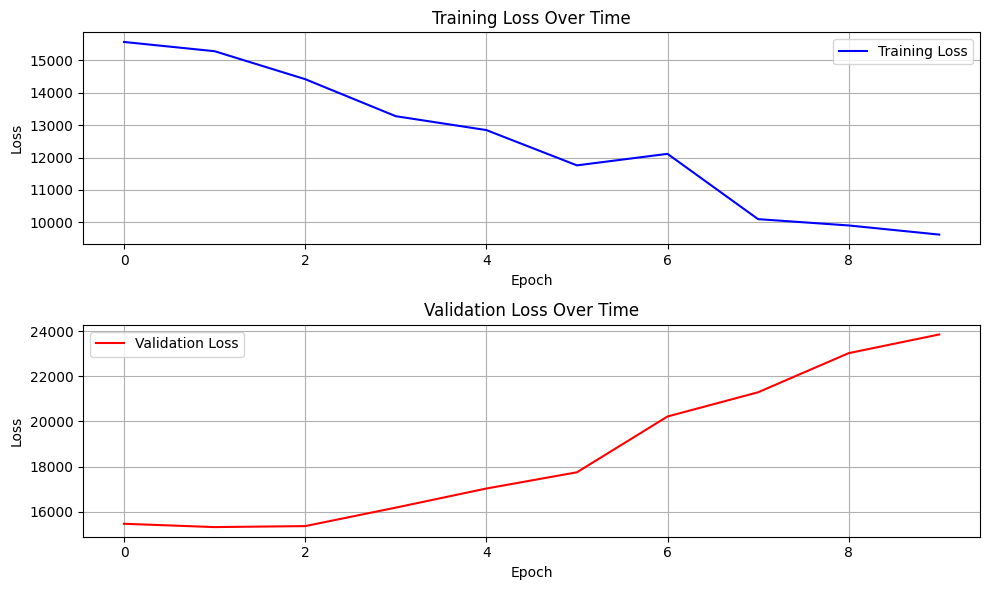

In [19]:
import matplotlib.pyplot as plt

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# Training loss subplot
ax1.plot(history.history["loss"], label="Training Loss", color="blue")
ax1.set_title("Training Loss Over Time")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Validation loss subplot
ax2.plot(history.history["val_loss"], label="Validation Loss", color="red")
ax2.set_title("Validation Loss Over Time")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
# plt.show() # Uncomment to show the plot

# <span style="color:#ff5f27">🗄️ Upload models to Hopsworks model registry </span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

Let's connect to the model registry using the [HSML library](https://docs.hopsworks.ai/machine-learning-api/latest) from Hopsworks.

In [20]:
mr = project.get_model_registry()

Now, we push the models to Hopsworks model registry:

In [21]:
query_model = hopsworks_integration.two_tower_serving.HopsworksQueryModel(
    model=model.query_model
)
query_model.register(
    mr=mr,
    feature_view=feature_view,
    query_df=dataset.properties["query_df"],
)

item_model = hopsworks_integration.two_tower_serving.HopsworksCandidateModel(
    model=model.item_model
)
item_model.register(
    mr=mr,
    feature_view=feature_view,
    item_df=dataset.properties["item_df"],
)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/179201 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/55 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/68922 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/561 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/165 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1213603/models/query_model/1


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/325967 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/56 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/765994 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/423 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/95 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1213603/models/candidate_model/1


## <span style="color:#ff5f27"> Inspecting the models in the Hopsworks model registry </span>

View results in [Hopsworks Serverless](https://rebrand.ly/serverless-github): **Data Science → Model Registry**

---

In [22]:
notebook_end_time = time.time()
notebook_execution_time = notebook_end_time - notebook_start_time

logger.info(
    f"⌛️ Notebook Execution time: {notebook_execution_time:.2f} seconds ~ {notebook_execution_time / 60:.2f} minutes"
)

2025-02-19 03:44:21.333 | INFO     | __main__:<cell line: 0>:4 - ⌛️ Notebook Execution time: 739.62 seconds ~ 12.33 minutes


# <span style="color:#ff5f27">→ Next Steps </span>

At this point you have a recommender system that is able to generate a set of candidate items for a customer. However, many of these could be poor, as the candidate model was trained with only a few subset of the features. In the next notebook, you'll train a *ranking model* to do more fine-grained predictions.